# **Imports**

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
import traceback
from googleapiclient.discovery import build
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import random
from PIL import Image
import requests
from io import BytesIO
%matplotlib inline

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True



---



---


# **Mount Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/bda/Final/

/content/drive/MyDrive/bda/Final




---



---


# **Dataset**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/bda/Final/youtube history data task 4/complete_history.csv')

In [5]:
len(df)

13671

In [6]:
df.head()

,Unnamed: 0,title,time,video_id,category_id,channel
0,0,They turned their Blind Audition into a CONCER...,2020-11-24T05:12:03.416Z,Ahh9GQaCo0s,24,Best of The Voice
1,1,"Jealous, Cake By The Ocean, Sucker Medley (Liv...",2020-11-24T05:04:33.691Z,LfnzCsEzNSk,10,JonasBrothersVEVO
2,2,Ariana Grande - Sweetner,2020-11-24T05:03:41.586Z,Zk1rCeIinSY,22,RoadTrip TV
3,3,Georges Hobeika Couture - how to make high fas...,2020-11-24T04:55:12.236Z,-LlXCbj-ARE,26,World Fashion Channel
4,4,BTS - HOME | J-HO Choreo Class l JUSTJERK,2020-11-24T04:54:50.831Z,7IxmgJlUoPE,24,JustJerk Dance Academy


In [7]:
df = df.drop(['Unnamed: 0'],axis=1)

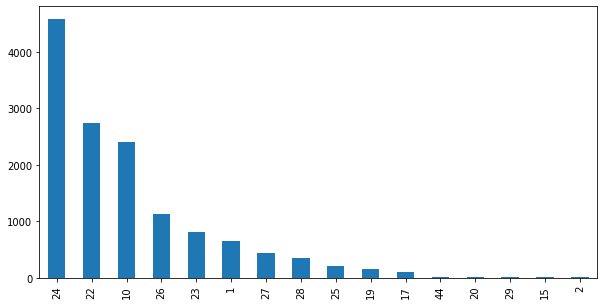

In [8]:
df['category_id'].value_counts().plot(x = 'genre', y ='count', kind = 'bar', figsize = (10,5)  )



*   **The videos from genres 24 - Entertainment, 22 - people and 10 - music are the most viewed**
*   **The content based recommender system can be built using top 5 genres to avoid imbalance in dataset**




In [9]:
dataset = df.loc[df['category_id'].isin([23,26,10,22,24])]

In [10]:
len(dataset)

11670



---



---


# **Preprocessing**

In [20]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

In [19]:
def make_lower_case(text):
    return text.lower()

In [18]:
def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

In [17]:
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [21]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [25]:
df['cleaned_title'] = ''
df['cleaned_title'] = df['title'].apply(_removeNonAscii)
df['cleaned_title'] = df.cleaned_title.apply(func = make_lower_case)
df['cleaned_title'] = df.cleaned_title.apply(func = remove_stop_words)
df['cleaned_title'] = df.cleaned_title.apply(func=remove_punctuation)
df['cleaned_title'] = df.cleaned_title.apply(func=remove_html)

In [26]:
df.head()

,title,time,video_id,category_id,channel,cleaned_title
0,They turned their Blind Audition into a CONCER...,2020-11-24T05:12:03.416Z,Ahh9GQaCo0s,24,Best of The Voice,turned blind audition concert voice top 10
1,"Jealous, Cake By The Ocean, Sucker Medley (Liv...",2020-11-24T05:04:33.691Z,LfnzCsEzNSk,10,JonasBrothersVEVO,jealous cake ocean sucker medley live billboar...
2,Ariana Grande - Sweetner,2020-11-24T05:03:41.586Z,Zk1rCeIinSY,22,RoadTrip TV,ariana grande sweetner
3,Georges Hobeika Couture - how to make high fas...,2020-11-24T04:55:12.236Z,-LlXCbj-ARE,26,World Fashion Channel,georges hobeika couture make high fashion
4,BTS - HOME | J-HO Choreo Class l JUSTJERK,2020-11-24T04:54:50.831Z,7IxmgJlUoPE,24,JustJerk Dance Academy,bts home j ho choreo class l justjerk




---



---


# **Transform into vectors using TF-IDF**

In [92]:
df['id']=[i for i in range(0,len(df))]

In [117]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['cleaned_title'])

cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

results = {}

for idx, row in df.iterrows():
    similar_indices = cosine_similarities[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities[idx][i], df['id'][i]) for i in similar_indices]

    results[row['id']] = similar_items[1:]
    
def item(id):
    return df.loc[df['id'] == id]['video_id'].tolist()[0].split(' - ')[0]

# Just reads the results out of the dictionary.
    """ 
    rec = data[['title', 'video_id']].iloc[movie_indices]
       
    # It reads the top 5 recommended book urls and print the images
    
    for i in rec['video_id']:
        url = 'https://img.youtube.com/vi/'+str(i)+'/sddefault.jpg'
        response = requests.get(i)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(plt.imshow(img))"""

In [157]:
def recommend(item_id, num):
    print("Videos related to : " + '"'+df['title'][item_id]+ '"')
    print("-------")
    recs = results[item_id][:num]
    #print(recs)
    for rec in recs:
        ind=rec[1]
        vid = df['video_id'][ind]
        url = 'https://img.youtube.com/vi/'+str(vid)+'/sddefault.jpg'
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        plt.figure()
        print(df['title'][ind])
        plt.imshow(img)
        

Videos related to : "Georges Hobeika Couture - how to make high fashion"
-------
Ep.8 이 여자 패션까지 바꿔줬습니다 I even changed her fashion.
Jennie Kim Shut Down Front Row Of The Chanel Fashion Show With Cardi B At Paris Fashion Week | TIME
Scandal High - Episode 1
BTS Jimin 15 Airport fashion
ICONIC Victoria's Secret Fashion Show Moments


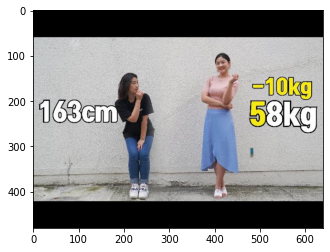

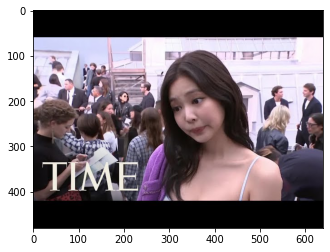

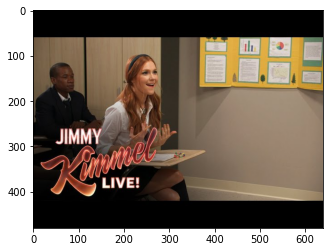

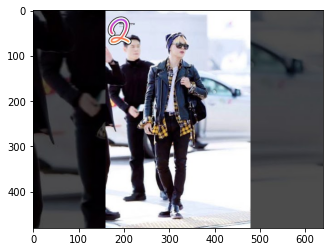

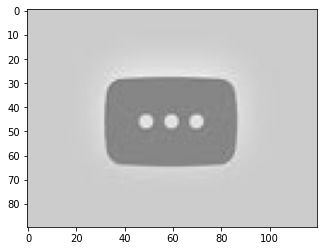

In [159]:
recommend(3, 5)